# Black-Scholes Algorithm Using Numba-dpex

## Sections
- [Black Sholes algorithm](#Black-Sholes-algorithm)
- _Code:_ [Implementation of Black Scholes targeting CPU using Numba JIT](#Implementation-of-Black-Scholes-targeting-CPU-using-Numba-JIT)
- _Code:_ [Implementation of Black Scholes targeting GPU using Kernels](#Implementation-of-Black-Scholes-targeting-GPU-using-Kernels)
- _Code:_ [Implementation of Black Scholes targeting GPU using Numpy](#Implementation-of-Black-Scholes-targeting-GPU-using-Numpy)



## Learning Objectives
* Build a Numba implementation of Black Scholes targeting CPU and GPU using Numba Jit
* Build a  Numba-Dpex  implementation of Black Scholes on CPU and GPU using Kernel approach
* Build a  Numba-Dpex implementation of Black Scholes on GPU using Numpy approach

## numba-dpex

Numba-dpex is a standalone extension to the Numba JIT compiler that adds SYCL programming capabilities to Numba. Numba-dpex is packaged as part of the IDP that comes with oneAPI base toolkit, and you don’t need to install any specific Conda packages. The support for SYCL is via SYCL runtime and other SYCL compilers are not supported by Numba-dpex.



## Black Sholes algorithm

The Black-Scholes program computes the price of a portfolio of options using partial differential equations. The entire computation performed by Black-Scholes is data-parallel, where each option can be priced independent of other options.

The Black-Scholes Model is one of the most important concepts in modern quantitative finance theory. Developed in 1973 by Fisher Black, Robert Merton, and Myron Scholes; it is still widely used today, and regarded as one of the best ways to determine fair prices of financial derivatives.

## Command Line parameters

| Type | Default Value | Description |
|:---|:---|:---|
| --steps | 10 | Number of workload runs |
| --step | 2  | Data growth factor on each iteration |
| --size | 2 ** 28 | Initial data size |
| --repeat | 1 | Iterations inside measured region |
| --json | False | Output json data filename |
| -d | 1 | Data Dimension |
| --usm | False | Use USM Shared |

### Implementation of Black-Scholes Formula

The Black-Scholes formula is used widely in almost every aspect of quantitative finance. The Black-Scholes calculation has essentially permeated every quantitative finance library by traders and quantitative analysts alike. 

Let’s look at a hypothetic situation in which a firm has to calculate European options for millions of financial instruments. For each instrument, it has current price, strike price, and option expiration time. For each set of these data, it makes several thousand Black-Scholes calculations, much like the way options of neighboring stock prices, strike prices, and different option expiration times were calculated.


# Implementation of Black Scholes targeting CPU using Numba JIT
In the following example, we introduce a naive Black-Sholes implementation that targets a CPU using the Numba JIT, where we calculate the Black-Sholes formula as described:

This is the decorator-based approach, where we offload data parallel code sections like parallel-for, and certain NumPy function calls. With the decorator method, a programmer needs to simply identify the most time-consuming parts of the program. If those parts can be parallelized, the programmer needs to just annotate those sections using Numba-Dpex, and can expect those code sections to execute on a GPU.

1. Inspect the code cell below and click run ▶ to save the code to a file.
2. Next run ▶ the cell in the __Build and Run__ section below the code to compile and execute the code.

In [1]:
%%writefile lab/black_sholes_jit_cpu.py
# Copyright (C) 2017-2018 Intel Corporation
#
# SPDX-License-Identifier: MIT

import dpctl
import base_bs_erf
import numba as nb
from math import log, sqrt, exp, erf

# blackscholes implemented as a parallel loop using numba.prange
@nb.njit(parallel=True, fastmath=True)
def black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put):
    mr = -rate
    sig_sig_two = vol * vol * 2

    for i in nb.prange(nopt):
        P = price[i]
        S = strike[i]
        T = t[i]

        a = log(P / S)
        b = T * mr

        z = T * sig_sig_two
        c = 0.25 * z
        y = 1.0 / sqrt(z)

        w1 = (a - b + c) * y
        w2 = (a - b - c) * y

        d1 = 0.5 + 0.5 * erf(w1)
        d2 = 0.5 + 0.5 * erf(w2)

        Se = exp(b) * S

        r = P * d1 - Se * d2
        call[i] = r
        put[i] = r - P + Se


def black_scholes(nopt, price, strike, t, rate, vol, call, put):
    # offload blackscholes computation to CPU (toggle level0 or opencl driver).
    
    black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put)


# call the run function to setup input data and performance data infrastructure
base_bs_erf.run("Numba@jit-loop-par", black_scholes)

Overwriting lab/black_sholes_jit_cpu.py


### Build and Run
Select the cell below and click run ▶ to compile and execute the code:

In [2]:
! chmod 755 q; chmod 755 run_black_sholes_jit_cpu.sh; if [ -x "$(command -v qsub)" ]; then ./q run_black_sholes_jit_cpu.sh; else ./run_black_sholes_jit_cpu.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2311510.v-qsvr-1           ...ub-singleuser u137620         00:00:29 R jupyterhub     
2311526.v-qsvr-1           ...matrix_mul.sh u137620                0 R batch          
2311527.v-qsvr-1           ...llows_data.sh u137620                0 R batch          
2311528.v-qsvr-1           ...es_jit_cpu.sh u137620                0 Q batch          

Waiting for Output ███████████████ Done⬇

########################################################################
#      Date:           Sun 04 Jun 2023 08:05:41 PM PDT
#    Job ID:           2311528.v-qsvr-1.aidevcloud
#      User:           u137620
# Resources:           cput=75

# Implementation of Black Scholes targeting GPU using Numba JIT
In the below example we introduce to a Naive Blacksholes implementation that targets a GPU using the Numba Jit where we calculate the blacksholes formula as described above.

1. Inspect the code cell below and click run ▶ to save the code to a file.
2. Next run ▶ the cell in the __Build and Run__ section below the code to compile and execute the code.

In [3]:
%%writefile lab/black_sholes_jit_gpu.py
# Copyright (C) 2017-2018 Intel Corporation
#
# SPDX-License-Identifier: MIT

import dpctl
import base_bs_erf_gpu
import numba as nb
from math import log, sqrt, exp, erf
from device_selector import get_device_selector

# blackscholes implemented as a parallel loop using numba.prange
@nb.njit(parallel=True, fastmath=True)
def black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put):
    mr = -rate
    sig_sig_two = vol * vol * 2

    for i in nb.prange(nopt):
        P = price[i]
        S = strike[i]
        T = t[i]

        a = log(P / S)
        b = T * mr

        z = T * sig_sig_two
        c = 0.25 * z
        y = 1.0 / sqrt(z)

        w1 = (a - b + c) * y
        w2 = (a - b - c) * y

        d1 = 0.5 + 0.5 * erf(w1)
        d2 = 0.5 + 0.5 * erf(w2)

        Se = exp(b) * S

        r = P * d1 - Se * d2
        call[i] = r
        put[i] = r - P + Se


def black_scholes(nopt, price, strike, t, rate, vol, call, put):
    # offload blackscholes computation to GPU (toggle level0 or opencl driver).
    with dpctl.device_context(get_device_selector(is_gpu=True)):
        black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put)


# call the run function to setup input data and performance data infrastructure
base_bs_erf_gpu.run("Numba@jit-loop-par", black_scholes)

Overwriting lab/black_sholes_jit_gpu.py


### Build and Run
Select the cell below and click run ▶ to compile and execute the code:

In [4]:
! chmod 755 q; chmod 755 run_black_sholes_jit_gpu.sh; if [ -x "$(command -v qsub)" ]; then ./q run_black_sholes_jit_gpu.sh; else ./run_black_sholes_jit_gpu.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2311510.v-qsvr-1           ...ub-singleuser u137620         00:00:36 R jupyterhub     
2311530.v-qsvr-1           ...es_jit_gpu.sh u137620                0 Q batch          

Waiting for Output ███████████████████ Done⬇

########################################################################
#      Date:           Sun 04 Jun 2023 08:05:57 PM PDT
#    Job ID:           2311530.v-qsvr-1.aidevcloud
#      User:           u137620
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u137620 is compiling AI numb

# Implementation of Black Scholes targeting GPU using Kernels

## Writing Explicit Kernels in numba-dpex

Writing a SYCL kernel using the `@numba_dpex.kernel` decorator has similar syntax to writing OpenCL kernels. As such, the numba-dpex module provides similar indexing and other functions as OpenCL. The indexing functions supported inside a `numba_dpex.kernel` are:

* numba_dpex.get_local_id : Gets the local ID of the item
* numba_dpex.get_local_size: Gets the local work group size of the device
* numba_dpex.get_group_id : Gets the group ID of the item
* numba_dpex.get_num_groups: Gets the number of gropus in a worksgroup

Refer https://intelpython.github.io/numba-dpex/latest/user_guides/kernel_programming_guide/index.html for more details.

In the following example we use dpex-kernel approach for explicit kernel programming where if the programmer wants to extract further performance from the offloaded code, the programmer can use the explicit kernel programming approach using dpex-kernels and tune the GPU parameterswhere we take advantage of the workgroups and the workitems in a device using the kernel approach

1. Inspect the code cell below and click run ▶ to save the code to a file.
2. Next run ▶ the cell in the __Build and Run__ section below the code to compile and execute the code.

In [5]:
%%writefile lab/black_sholes_kernel.py
# Copyright (C) 2017-2018 Intel Corporation
#
# SPDX-License-Identifier: MIT

import dpctl
import base_bs_erf_gpu
import numba_dpex
from math import log, sqrt, exp, erf
from device_selector import get_device_selector

# blackscholes implemented using dpex.kernel
@numba_dpex.kernel(
    access_types={"read_only": ["price", "strike", "t"], "write_only": ["call", "put"]}
)
def black_scholes(nopt, price, strike, t, rate, vol, call, put):
    mr = -rate
    sig_sig_two = vol * vol * 2

    i = numba_dpex.get_global_id(0)

    P = price[i]
    S = strike[i]
    T = t[i]

    a = log(P / S)
    b = T * mr

    z = T * sig_sig_two
    c = 0.25 * z
    y = 1.0 / sqrt(z)

    w1 = (a - b + c) * y
    w2 = (a - b - c) * y

    d1 = 0.5 + 0.5 * erf(w1)
    d2 = 0.5 + 0.5 * erf(w2)

    Se = exp(b) * S

    r = P * d1 - Se * d2
    call[i] = r
    put[i] = r - P + Se


def black_scholes_driver(nopt, price, strike, t, rate, vol, call, put):
    # offload blackscholes computation to GPU (toggle level0 or opencl driver).
    with dpctl.device_context(get_device_selector(is_gpu=True)):
        black_scholes[nopt, numba_dpex.DEFAULT_LOCAL_SIZE](
            nopt, price, strike, t, rate, vol, call, put
        )


# call the run function to setup input data and performance data infrastructure
base_bs_erf_gpu.run("Numba@jit-loop-par", black_scholes_driver)

Overwriting lab/black_sholes_kernel.py


### Build and Run
Select the cell below and click run ▶ to compile and execute the code:

In [6]:
! chmod 755 q; chmod 755 run_black_sholes_kernel.sh; if [ -x "$(command -v qsub)" ]; then ./q run_black_sholes_kernel.sh; else ./run_black_sholes_kernel.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2311510.v-qsvr-1           ...ub-singleuser u137620         00:00:36 R jupyterhub     
2311531.v-qsvr-1           run_dbscan.sh    u137620                0 R batch          
2311532.v-qsvr-1           ...les_kernel.sh u137620                0 Q batch          

Waiting for Output ███████████████████ Done⬇

########################################################################
#      Date:           Sun 04 Jun 2023 08:06:17 PM PDT
#    Job ID:           2311532.v-qsvr-1.aidevcloud
#      User:           u137620
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
##################

## Implementation of Black Scholes targeting GPU using Numpy


In the following example, we can observe the Black Scholes NumPy implementation and we target the GPU using the NumPy approach.

1. Inspect the code cell below and click run ▶ to save the code to a file.
2. Next run ▶ the cell in the __Build and Run__ section below the code to compile and execute the code.

In [7]:
%%writefile lab/black_sholes_numpy_graph.py
# Copyright (C) 2017-2018 Intel Corporation
#
# SPDX-License-Identifier: MIT

# Copyright (C) 2017-2018 Intel Corporation
#
# SPDX-License-Identifier: MIT

import dpctl
import base_bs_erf_graph
import numba as nb
import numpy as np
from numpy import log, exp, sqrt
from math import erf
from device_selector import get_device_selector

# Numba does know erf function from numpy or scipy
@nb.vectorize(nopython=True)
def nberf(x):
    return erf(x)


# blackscholes implemented using numpy function calls
@nb.jit(nopython=True, parallel=True, fastmath=True)
def black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put):
    mr = -rate
    sig_sig_two = vol * vol * 2

    P = price
    S = strike
    T = t

    a = log(P / S)
    b = T * mr

    z = T * sig_sig_two
    c = 0.25 * z
    y = 1.0 / sqrt(z)

    w1 = (a - b + c) * y
    w2 = (a - b - c) * y

    d1 = 0.5 + 0.5 * nberf(w1)
    d2 = 0.5 + 0.5 * nberf(w2)

    Se = exp(b) * S

    r = P * d1 - Se * d2
    call[:] = r  # temporary `r` is necessary for faster `put` computation
    put[:] = r - P + Se


def black_scholes(nopt, price, strike, t, rate, vol, call, put):
    # offload blackscholes computation to GPU (toggle level0 or opencl driver).
    with dpctl.device_context(get_device_selector(is_gpu=True)):
        black_scholes_kernel(nopt, price, strike, t, rate, vol, call, put)


# call the run function to setup input data and performance data infrastructure
base_bs_erf_graph.run("Numba@jit-numpy", black_scholes)

Overwriting lab/black_sholes_numpy_graph.py


### Build and Run
Select the cell below and click run ▶ to compile and execute the code:

In [8]:
! chmod 755 q; chmod 755 run_black_sholes_numpy_graph.sh; if [ -x "$(command -v qsub)" ]; then ./q run_black_sholes_numpy_graph.sh; else ./run_black_sholes_numpy_graph.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2311510.v-qsvr-1           ...ub-singleuser u137620         00:00:46 R jupyterhub     
2311533.v-qsvr-1           ...umpy_graph.sh u137620                0 Q batch          

Waiting for Output ████████████████████ Done⬇

########################################################################
#      Date:           Sun 04 Jun 2023 08:06:37 PM PDT
#    Job ID:           2311533.v-qsvr-1.aidevcloud
#      User:           u137620
# Resources:           cput=75:00:00,neednodes=1:gpu:ppn=2,nodes=1:gpu:ppn=2,walltime=06:00:00
########################################################################

## u137620 is compiling AI num

# Plot GPU Results

The algorithm below is detecting Calls and Puts verses Current price for a strike price in range 23 to 25 and plots the results in a graph as shown below. 

### View the results
Select the cell below and click run ▶ to view the graph:

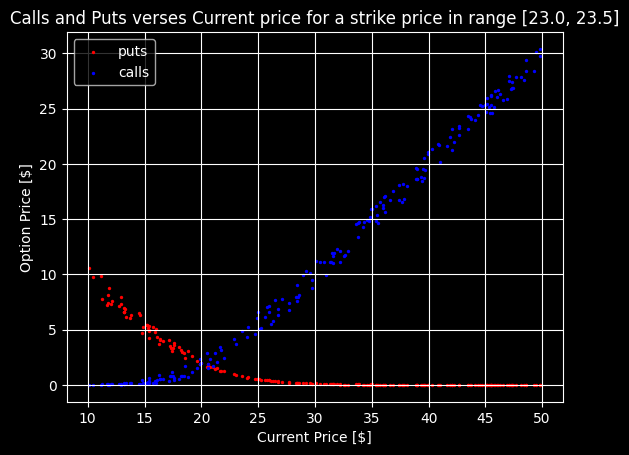

In [9]:
from matplotlib import pyplot as plt 
import numpy as np 

def read_dictionary(fn):
    import joblib
    # Load data (deserialize)
    with open(fn, 'rb') as handle:
        dictionary = joblib.load(handle)
    return dictionary
resultsDict = read_dictionary('resultsDict.dat')
limit = 10
call = resultsDict['call']
put = resultsDict['put']
price = resultsDict['price']
strike = resultsDict['strike']

plt.style.use('dark_background')
priceRange = [23.0, 23.5]
# strikeIndex = np.where((price >= priceRange[0]) & (price < priceRange[1]) )[0]
# plt.scatter(strike[strikeIndex], put[strikeIndex], c= 'r', s = 2, alpha = 1, label = 'puts')
# plt.scatter(strike[strikeIndex], call[strikeIndex], c= 'b', s = 2, alpha = 1, label = 'calls')
# plt.title('Calls and Puts verses Strike for a current price in range {}'.format(priceRange))
# plt.ylabel('Option Price [$]')
# plt.xlabel('Strike Price [$]')
# plt.legend()
# plt.grid()

strikeRange = [23.0, 23.5]
strikeIndex = np.where((strike >= strikeRange[0]) & (strike < strikeRange[1]) )[0]
plt.scatter(price[strikeIndex], put[strikeIndex], c= 'r', s = 2, alpha = 1, label = 'puts')
plt.scatter(price[strikeIndex], call[strikeIndex], c= 'b', s = 2, alpha = 1, label = 'calls')
plt.title('Calls and Puts verses Current price for a strike price in range {}'.format(priceRange))
plt.ylabel('Option Price [$]')
plt.xlabel('Current Price [$]')
plt.legend()
plt.grid()


_If the Jupyter cells are not responsive or if they error out when you compile the code samples, please restart the Jupyter Kernel: 
"Kernel->Restart Kernel and Clear All Outputs" and compile the code samples again__

### Advsior Roofline Report

A Roofline chart is a visual representation of application performance in relation to hardware limitations, including memory bandwidth and computational peaks.  Intel Advisor includes an automated Roofline tool that measures and plots the chart on its own, so all you need to do is read it.

The chart can be used to identify not only where bottlenecks exist, but what’s likely causing them, and which ones will provide the most speedup if optimized.

The Survey is usually the first analysis you want to run with Intel® Advisor. The survey is mainly used to time your application as well as the different loops and functions. 

The second step is to run the trip count analysis. This step uses instrumentation to count how many iterations you are running in each loops. Adding the option -flop will also provide the precise number of operations executed in each of your code sections.

Execute the following line to display the roofline results 


* Run the Survey analysis with the --profile-gpu option

```
advisor --collect=survey --profile-gpu -run-pass-thru=--no-altstack -project-dir=roofline --search-dir src:r=. python lab/black_sholes_kernel.py --steps 1 --size 268435456 --repeat 5 --json result_gpu.json --usm
```
* Run the Trip Counts and FLOP analysis with --profile-gpu option:

```
advisor --collect=tripcounts --profile-gpu --project-dir=roofline "--search-dir src:r=." --flop --no-trip-counts python lab/black_sholes_kernel.py --steps 1 --size 268435456 --repeat 5 --json result_gpu.json --usm
```
* Generate a GPU Roofline report:

```
advisor --report=roofline --gpu --project-dir=roofline --report-output=roofline/roofline.html
```

### Advisor Roofline Report

Execute the following line to display the roofline results 


In [10]:
run lab/mm_basic_roofline.py

## Genrating the Vtune reports
Below exercises we use VTune™  analyzer as a way to see what is going on with each implementation. The information was the high-level hotspot generated from the collection and rendered in an HTML iframe. Depending on the options chosen, many of the VTune analyzer's performance collections can be rendered via HTML pages. The below vtune scripts collect GPU offload and GPU hotspots information.
```
vtune -run-pass-thru=--no-altstack -collect=gpu-offload -result-dir=vtune_dir python lab/black_sholes_kernel.py --steps 1 --size 268435456 --repeat 5 --json result_gpu.json --usm
```

```
vtune -run-pass-thru=--no-altstack -collect=gpu-hotspots -result-dir=vtune_hotspots_dir_new python lab/black_sholes_kernel.py --steps 1 --size 268435456 --repeat 5 --json result_gpu.json --usm
```

```
vtune -report summary -result-dir vtune_dir -format html -report-output output.html
```

```
vtune -report summary -result-dir vtune_hotspots_dir -format html -report-output output_hotspots.html
```

In [11]:
run lab/mm_basic_vtune.py

## Summary
In this module you will have learned the following:
* Numba implementation of Black Scholes targeting a CPU and GPU using Numba JIT
* Numba-dpex  implementation of Black Scholes on a CPU and GPU using the kernel approach
* Numba-dpex  implementation of Black Scholes on a GPU using Numpy approach